# Emotion Words & Description Density

**Goal:** Count color terms and compare description density.

# Setup: Load Texts

This notebook needs **Crime And Punishment**

**How to provide the texts:**
1. Download the book from Project Gutenberg as txts. [go to https://www.gutenberg.org/ebooks/2554 ]

2. Place the text file in the "data" folder with name:
   - `Crime-punishment.txt`  (Crime And Punishment)



In [1]:
import re
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
import re

# Function to load the text from a file
def load_text(local_crime: str = '../data/Crime-punishment.txt'):
    with open(local_crime, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Function to normalize the text (basic normalization steps like lowercasing, removing special characters, etc.)
def normalize_text(text):
    # Lowercase and remove non-alphanumeric characters (you can adjust this step)
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

# Function to split text into chapters based on regex pattern
def split_into_chapters(text):
    # Split by "CHAPTER X" where X can be a roman numeral or a number
    chapters_raw = re.split(r"\bchapter\s+[ivxlcdm0-9]+\b", text, flags=re.IGNORECASE)
    chapters = [ch.strip() for ch in chapters_raw if ch.strip()]
    return chapters

# Function to tokenize the text (basic tokenization)
def tokenize(text, stopwords=None):
    words = re.findall(r'\b\w+\b', text)  # Find all words
    if stopwords:
        words = [word for word in words if word not in stopwords]
    return words

# Example of processing the book
local_crime = "../data/Crime-punishment.txt"  # Path relative to the script
text = load_text(local_crime)
normalized_text = normalize_text(text)

# Split the book into chapters
chapters = split_into_chapters(normalized_text)
print("Total detected chapters:", len(chapters))

# Define early and late chapters
early_chapters = chapters[:10]  # First 10 chapters
late_chapters = chapters[-10:]  # Last 10 chapters

# Combine early and late chapters into text
early_text = " ".join(early_chapters)
late_text = " ".join(late_chapters)

# Tokenize all three versions
tokens_all = tokenize(normalized_text)
tokens_early = tokenize(early_text)
tokens_late = tokenize(late_text)

print("All tokens:", len(tokens_all), "| Early tokens:", len(tokens_early), "| Late tokens:", len(tokens_late))
print("Early sample:", tokens_early[:12])
print("Late sample:", tokens_late[:12])


Total detected chapters: 41
All tokens: 208785 | Early tokens: 52880 | Late tokens: 43713
Early sample: ['on', 'an', 'exceptionally', 'hot', 'evening', 'early', 'in', 'july', 'a', 'young', 'man', 'came']
Late sample: ['a', 'strange', 'period', 'began', 'for', 'raskolnikov', 'it', 'was', 'as', 'though', 'a', 'fog']


In [3]:
from pathlib import Path

def load_texts(local_crime: str = '../data/Crime-punishment.txt'):
    """Load Crime and Punishment text from disk.

    Parameters
    ----------
    local_crime : str
        Path to Crime and Punishment text file. Defaults to '../data/Crime-punishment.txt'.

    Returns
    -------
    str
        crime_text.

    Raises
    ------
    FileNotFoundError
        If the file is missing.

    Extra Notes
    -----------
    - Using UTF-8 with `errors='ignore'` avoids codec exceptions on
      older Project Gutenberg dumps or inconsistent encodings.
    """
    p1 = Path(local_crime)

    # Fail fast with a clear message if a file is missing
    if not p1.exists():
        raise FileNotFoundError(
            f"Missing file: {p1}\n"
            "→ Please place 'Crime-punishment.txt' at this path or update load_texts(...)."
        )

    # Read the file (UTF-8; ignore undecodable bytes to stay robust)
    crime = p1.read_text(encoding='utf-8', errors='ignore')
    return crime

def normalize(text: str) -> str:
    """Normalize a Gutenberg-like text for tokenization.

    Steps
    -----
    1) Heuristically strip Project Gutenberg headers/footers if present
       (looks for *** START ... *** END markers).
    2) Normalize newlines to '\n'.

    Parameters
    ----------
    text : str
        Raw text as loaded from disk (can be empty).

    Returns
    -------
    str
        Cleaned text suitable for tokenization and counting.
    """
    if not text:
        return ''
    # Clip to the main body if markers are present.
    start = text.find('*** START')
    end   = text.find('*** END')
    if start != -1 and end != -1 and end > start:
        text = text[start:end]
    # Normalize Windows line endings.
    return text.replace('\r\n', '\n')

# Load raw Crime and Punishment text (forgiving: returns '' if the file is missing)
crime_raw = load_texts()

# Normalize for tokenization
crime = normalize(crime_raw)

print(f"Crime and Punishment chars: {len(crime):,}")


Crime and Punishment chars: 1,211,670


### Helpers: Tokenization

In [4]:
import re

WORD_RE = re.compile(r"[A-Za-z']+")  # keep apostrophes in words (e.g., don't -> don't)

def words(text: str):
    """Simple word tokenizer (lowercased, ASCII letters + apostrophes).

    Pros
    ----
    - Very fast and dependency-free.
    - Good enough for frequency/keyness demonstrations.

    Cons
    ----
    - No punctuation words, no sentence boundaries, no POS tags.
    - May treat possessives inconsistently across sources.

    Returns
    -------
    list[str]
        Lowercased word words.
    """
    return WORD_RE.findall(text.lower())


def sentences(text: str):
    """Naive sentence splitter using punctuation boundaries.

    Uses a regex to split on '.', '!', '?' followed by whitespace.
    Because this is heuristic, treat results as approximate.

    Returns
    -------
    list[str]
        Sentence-like strings.
    """
    return [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]

# Tokenizing the text for Crime and Punishment only
crime_words = words(crime)

# Splitting the text into sentences for Crime and Punishment only
crime_sentences = sentences(crime)

# Printing word and sentence counts for Crime and Punishment only
print(f"Crime and Punishment words: {len(crime_words):,}")
print(f"Crime and Punishment sentences: {len(crime_sentences):,}")

Crime and Punishment words: 212,681
Crime and Punishment sentences: 16,927


In [6]:
# Rolling emotion windows for *Crime and Punishment*
def rolling_emotion_windows(tokens, window=800, step=200, emotion_list=EMOTION_LIST):
    hits_per_window = []
    for i in range(0, max(1, len(tokens)-window+1), step):
        chunk = tokens[i:i+window]
        c = sum(1 for w in chunk if w in emotion_list)  # count the emotions/themes in the window
        hits_per_window.append((i, i+window, c, c * (100000/window)))  # per 100k
    return hits_per_window

# Nearest sentence span (for previewing emotional/thematic bursts)
def nearest_sentence_span(tokens, sents, start_idx, end_idx):
    text = " ".join(tokens[start_idx:end_idx])
    head = " ".join(tokens[start_idx:start_idx+20])
    for k, s in enumerate(sents):
        if head[:50] in s:
            j0 = max(0, k-1); j1 = min(len(sents), k+3)
            return j0, j1, " ".join(sents[j0:j1])
    return None, None, text[:500]

# Run emotion/theme analysis for Crime and Punishment
w_roll = rolling_emotion_windows(crime_words, window=800, step=200)

# Top 5 bursts by per-100k for Crime and Punishment
w_top = sorted(w_roll, key=lambda x: x[3], reverse=True)[:5]

# Print emotional/theme bursts for Crime and Punishment
print("=== Crime and Punishment emotion bursts ===")
for a, b, h, rate in w_top:
    j0, j1, preview = nearest_sentence_span(crime_words, crime_sentences, a, b)
    print(f"[tokens {a}-{b}] hits={h} | {rate:.0f} per 100k")
    print(preview[:400], "…\n")

=== Crime and Punishment emotion bursts ===
[tokens 18200-19000] hits=8 | 1000 per 100k
bread and water she would not sell her soul she would not barter her moral freedom for comfort she would not barter it for all schleswig holstein much less mr luzhin s money no dounia was not that sort when i knew her and she is still the same of course yes there s no denying the svidriga lovs are a bitter pill it s a bitter thing to spend one s life a governess in the provinces for two hundred ro …

[tokens 211600-212400] hits=8 | 1000 per 100k
and sometimes did not offer it at all as though afraid he would repel it he always took her hand as though with repugnance always seemed vexed to meet her and was sometimes obstinately silent throughout her visit sometimes she trembled epilogue before him and went away deeply grieved but now their hands did not part he stole a rapid glance at her and dropped his eyes on the ground without speaking …

[tokens 18000-18800] hits=7 | 875 per 100k
did not know yo

ALIASES USED: ['raskolnikov', 'rodion romanovich raskolnikov', 'rodion romanovich', 'rodion', 'rodya', 'rodka', 'rodenka', 'the student', 'the young man', 'the lodger', 'the murderer', 'the author of the article', 'the former student']
Total chapters: 41
Early {'anger_sadness': 27, 'positive_emotion': 22}
Last {'anger_sadness': 28, 'positive_emotion': 33}


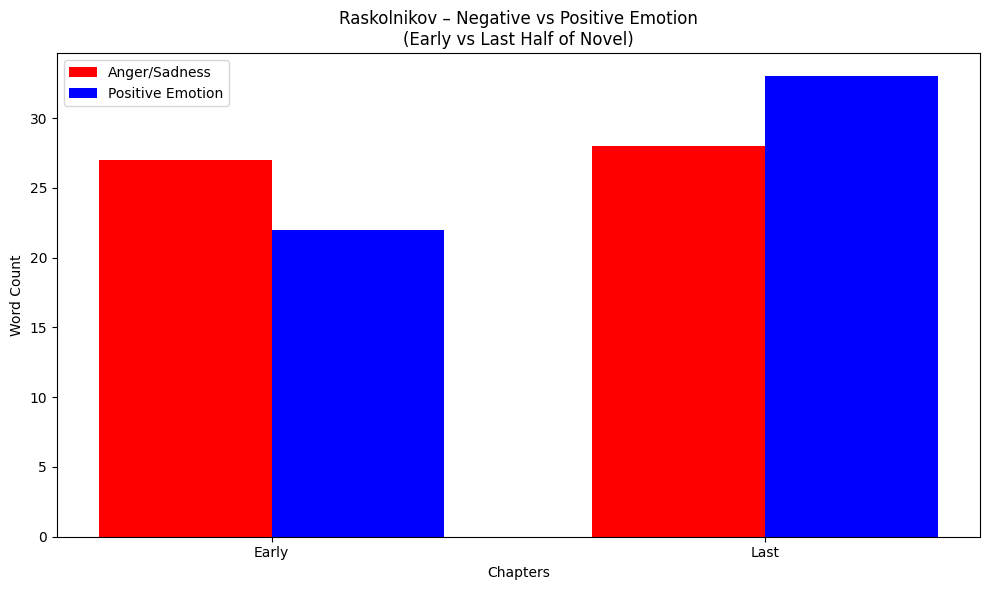

In [38]:
import json
import re
from collections import Counter
import matplotlib.pyplot as plt

# ================== EMOTION WORDS ================== #
# ---- Anger ----
ANGER_WORDS = {
    "anger", "angered", "angry", "angrily",
    "rage", "raging",
    "fury", "furious", "furiously",
    "hate", "hated", "hateful", "hatred",
    "disgust", "disgusted", "disgusting", "disgustingly",
    "loath", "loathe", "loathing", "loathsome",
    "indignant", "indignantly", "indignation",
    "annoy", "annoyed", "annoying", "annoyance",
    "irritated", "irritating", "irritation", "irritably",
    "resent", "resented", "resentful", "resentfully", "resentment",
    "wrath", "wrathful", "wrathfully",
    "savage",
    "violence", "violent", "violently",
    "vexed", "vexation",
    "outrage", "outraged", "outrageous",
    "spite", "spiteful",
    "sullen"
}

# ---- Sadness ----
SADNESS_WORDS = {
    "sad", "sadly", "sadness",
    "sorrow", "sorrows", "sorrowful",
    "grief", "grieving", "grieved",
    "weep", "wept", "weeping",
    "cry", "cried", "crying", "cries",
    "tear", "tears", "tearful", "tearfully",
    "despair", "despairing",
    "melancholy", "melancholic",
    "gloom", "gloomy",
    "lament", "lamented", "lamentation",
    "wretched", "wretchedly", "wretchedness",
    "miserable", "misery",
    "pain", "painful", "painfully",
    "anguish", "anguished",
    "suffer", "suffers", "suffering",
    "forlorn",
    "dreary",
    "hopeless", "hopelessness",
    "remorse", "remorseful",
    "tragic", "tragedy",
    "terror", "terrified", "terrifying",
    "afflicted", "affliction"
}

# ---- Merge Anger + Sadness ----
ANGER_SADNESS_WORDS = ANGER_WORDS | SADNESS_WORDS

# ---- Positive Emotion (Joy + Faith/Redemption) ----
POSITIVE_EMOTION_WORDS = {
    # Joy
    "joy", "joyful", "joyfully",
    "happy", "happiest", "happiness",
    "glad",
    "delight", "delightful", "delightfully",
    "pleasure", "pleasant", "pleasantly", "pleased",
    "cheer", "cheerful", "cheerfully",
    "smile", "smiled", "smiles", "smiling",
    "laugh", "laughed", "laughing", "laughter",
    "comfort", "comforted", "comforts",
    "comfortable", "comfortably",
    "peaceful", "peacefully",
    "hope", "hoped", "hopeful", "hopefully",

    # Faith / redemption / justice
    "faithful", "faithfully",
    "christ", "christened", "christian", "christmas",
    "cross", "crosses",
    "holy",
    "saint", "saints",

    "repent", "repented", "redeem",
    "redeemed", "redemption",
    "atonement", "atone", "regret", "sorry",
    "lament", "bewail",
    "justice", "punishment",
    "innocent",
    "sentence",

    "confess", "confessed", "confessing",
    "confession", "confessions", "confessor",

    "forgive", "forgiven", "forgiveness", "forgave",
    "mercy",
}

# Emotion dictionary
EMOTION_DICT = {
    "anger_sadness": ANGER_SADNESS_WORDS,
    "positive_emotion": POSITIVE_EMOTION_WORDS
}

# ------------------ HELPERS ------------------ #
def load_character_data(json_file: str):
    with open(json_file, 'r', encoding='utf-8') as f:
        return json.load(f)

def load_text(local_crime: str = '../data/Crime-punishment.txt'):
    with open(local_crime, 'r', encoding='utf-8') as f:
        return f.read()

def normalize_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def split_into_chapters(text: str):
    chapters_raw = re.split(r"\bchapter\s+[ivxlcdm0-9]+\b", text, flags=re.IGNORECASE)
    return [ch.strip() for ch in chapters_raw if ch.strip()]

def split_into_sentences(text: str):
    return re.split(r'(?<=[.!?])\s+', text)

def tokenize_norm(text: str):
    return re.findall(r'\b\w+\b', text)

def count_emotion_categories(tokens, emotion_dict=EMOTION_DICT):
    counts = {cat: 0 for cat in emotion_dict}
    for tok in tokens:
        for cat, words in emotion_dict.items():
            if tok in words:
                counts[cat] += 1
    return counts

# ------------------ LOAD DATA ------------------ #
local_crime = "../data/Crime-punishment.txt"
json_file   = "Character Library/Crime_punishment.json"

text_full = load_text(local_crime)
character_data = load_character_data(json_file)

# Extract Raskolnikov aliases
rask = character_data.get("Rodion_Raskolnikov", {})
aliases_raw = rask.get("aliases", [])

aliases = []
for a in aliases_raw:
    if isinstance(a, str):
        aliases.append(a)
    elif isinstance(a, dict) and "text" in a:
        aliases.append(a["text"])

normalized_aliases = [normalize_text(alias) for alias in aliases]

if "raskolnikov" not in normalized_aliases:
    normalized_aliases.append("raskolnikov")

print("ALIASES USED:", normalized_aliases)

# ------------------ SPLIT INTO CHAPTERS ------------------ #
chapters = split_into_chapters(text_full)
n_chapters = len(chapters)
print("Total chapters:", n_chapters)

half = n_chapters // 2

early_chapters = chapters[:10]
late_chapters  = chapters[-10:]

phase_names = ["Early", "Last"]
phase_chapters = [early_chapters, late_chapters]

# ------------------ COUNT EMOTIONS ------------------ #
phase_counts = []

for phase_name, chaps in zip(phase_names, phase_chapters):
    tokens_for_phase = []

    for chap in chaps:
        sentences = split_into_sentences(chap)

        for sent in sentences:
            norm = normalize_text(sent)

            if any(re.search(r'\b' + re.escape(alias) + r'\b', norm)
                   for alias in normalized_aliases):
                tokens_for_phase.extend(tokenize_norm(norm))

    counts = count_emotion_categories(tokens_for_phase)
    phase_counts.append(counts)
    print(phase_name, counts)

# ------------------ PLOT ------------------ #
anger_sad_values = [pc["anger_sadness"] for pc in phase_counts]
positive_values  = [pc["positive_emotion"] for pc in phase_counts]

x = range(len(phase_names))
bar_width = 0.35

plt.figure(figsize=(10, 6))

plt.bar([i - bar_width/2 for i in x], anger_sad_values,
        width=bar_width, color="red", label="Anger/Sadness")

plt.bar([i + bar_width/2 for i in x], positive_values,
        width=bar_width, color="blue", label="Positive Emotion")

plt.xticks(x, phase_names)
plt.xlabel("Chapters")
plt.ylabel("Word Count")
plt.title("Raskolnikov – Negative vs Positive Emotion\n(Early vs Last Half of Novel)")
plt.legend()

plt.tight_layout()
plt.show()